In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfield
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.FashionMNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.FashionMNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99995
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.2, 0.15]), 'fb': np.array([0.15, 0.1])}

# neural_lr_start = 0.1
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.05
# use_random_sign_beta = True
# use_three_phase = False

activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.3, 0.22]), 'fb': np.array([np.nan, 0.07])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 30
hopfield_g = 0.3
use_random_sign_beta = True
use_three_phase = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.13228333333333334


In [6]:
seed_ = 20
np.random.seed(seed_)
torch.manual_seed(seed_)
    
trn_acc_list = []
tst_acc_list = []

n_epochs = 50

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
#     print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [03:43, 13.43it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.7989666666666667, Test Accuracy : 0.7905
Nudged Information ratio: [0.09099274]


3000it [03:44, 13.39it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.8573833333333334, Test Accuracy : 0.8415
Nudged Information ratio: [0.09956399]


3000it [04:07, 12.12it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.8560666666666666, Test Accuracy : 0.8403
Nudged Information ratio: [0.10454406]


3000it [03:47, 13.16it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.8725333333333334, Test Accuracy : 0.8543
Nudged Information ratio: [0.10493372]


3000it [04:03, 12.34it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.86975, Test Accuracy : 0.8499
Nudged Information ratio: [0.1104781]


3000it [03:55, 12.73it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.8786666666666667, Test Accuracy : 0.86
Nudged Information ratio: [0.11791849]


3000it [03:56, 12.68it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.8841166666666667, Test Accuracy : 0.8667
Nudged Information ratio: [0.1180886]


3000it [04:05, 12.23it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.8826166666666667, Test Accuracy : 0.8625
Nudged Information ratio: [0.11891514]


3000it [03:49, 13.05it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.8912, Test Accuracy : 0.8703
Nudged Information ratio: [0.11280448]


3000it [04:10, 11.98it/s]
0it [00:00, ?it/s]

Epoch : 10, Train Accuracy : 0.8937833333333334, Test Accuracy : 0.8712
Nudged Information ratio: [0.11011066]


3000it [03:44, 13.36it/s]
0it [00:00, ?it/s]

Epoch : 11, Train Accuracy : 0.8935833333333333, Test Accuracy : 0.872
Nudged Information ratio: [0.10484188]


3000it [04:10, 11.99it/s]
0it [00:00, ?it/s]

Epoch : 12, Train Accuracy : 0.8970166666666667, Test Accuracy : 0.8741
Nudged Information ratio: [0.10781232]


3000it [03:45, 13.30it/s]
0it [00:00, ?it/s]

Epoch : 13, Train Accuracy : 0.8990166666666667, Test Accuracy : 0.8746
Nudged Information ratio: [0.11264702]


3000it [04:09, 12.01it/s]
0it [00:00, ?it/s]

Epoch : 14, Train Accuracy : 0.89935, Test Accuracy : 0.8755
Nudged Information ratio: [0.08849315]


3000it [03:55, 12.72it/s]
0it [00:00, ?it/s]

Epoch : 15, Train Accuracy : 0.9004, Test Accuracy : 0.8751
Nudged Information ratio: [0.10480893]


3000it [03:59, 12.53it/s]
0it [00:00, ?it/s]

Epoch : 16, Train Accuracy : 0.9023, Test Accuracy : 0.8768
Nudged Information ratio: [0.09574718]


3000it [04:02, 12.36it/s]
0it [00:00, ?it/s]

Epoch : 17, Train Accuracy : 0.9052166666666667, Test Accuracy : 0.8794
Nudged Information ratio: [0.09752725]


3000it [03:51, 12.94it/s]
0it [00:00, ?it/s]

Epoch : 18, Train Accuracy : 0.9044, Test Accuracy : 0.8799
Nudged Information ratio: [0.09408312]


3000it [04:08, 12.09it/s]
0it [00:00, ?it/s]

Epoch : 19, Train Accuracy : 0.9059333333333334, Test Accuracy : 0.8793
Nudged Information ratio: [0.09268089]


3000it [03:45, 13.31it/s]
0it [00:00, ?it/s]

Epoch : 20, Train Accuracy : 0.9068166666666667, Test Accuracy : 0.8797
Nudged Information ratio: [0.09042742]


3000it [04:09, 12.04it/s]
0it [00:00, ?it/s]

Epoch : 21, Train Accuracy : 0.9072, Test Accuracy : 0.8801
Nudged Information ratio: [0.09516069]


3000it [03:44, 13.34it/s]
0it [00:00, ?it/s]

Epoch : 22, Train Accuracy : 0.9078666666666667, Test Accuracy : 0.8809
Nudged Information ratio: [0.08588905]


3000it [04:09, 12.01it/s]
0it [00:00, ?it/s]

Epoch : 23, Train Accuracy : 0.9070666666666667, Test Accuracy : 0.8802
Nudged Information ratio: [0.08106882]


3000it [03:53, 12.88it/s]
0it [00:00, ?it/s]

Epoch : 24, Train Accuracy : 0.9085166666666666, Test Accuracy : 0.8802
Nudged Information ratio: [0.091798]


3000it [04:01, 12.42it/s]
0it [00:00, ?it/s]

Epoch : 25, Train Accuracy : 0.9065333333333333, Test Accuracy : 0.8774
Nudged Information ratio: [0.10181215]


3000it [03:59, 12.51it/s]
0it [00:00, ?it/s]

Epoch : 26, Train Accuracy : 0.9091666666666667, Test Accuracy : 0.8809
Nudged Information ratio: [0.07743083]


3000it [03:53, 12.83it/s]
0it [00:00, ?it/s]

Epoch : 27, Train Accuracy : 0.9091333333333333, Test Accuracy : 0.8797
Nudged Information ratio: [0.08196383]


3000it [03:07, 15.96it/s]
0it [00:00, ?it/s]

Epoch : 28, Train Accuracy : 0.9093333333333333, Test Accuracy : 0.8818
Nudged Information ratio: [0.07631214]


3000it [02:35, 19.35it/s]
0it [00:00, ?it/s]

Epoch : 29, Train Accuracy : 0.90945, Test Accuracy : 0.8804
Nudged Information ratio: [0.08475881]


3000it [02:31, 19.77it/s]
0it [00:00, ?it/s]

Epoch : 30, Train Accuracy : 0.9092666666666667, Test Accuracy : 0.8803
Nudged Information ratio: [0.09397265]


3000it [03:07, 16.02it/s]
0it [00:00, ?it/s]

Epoch : 31, Train Accuracy : 0.9098166666666667, Test Accuracy : 0.8803
Nudged Information ratio: [0.08953174]


3000it [02:51, 17.53it/s]
0it [00:00, ?it/s]

Epoch : 32, Train Accuracy : 0.90845, Test Accuracy : 0.8802
Nudged Information ratio: [0.09010547]


3000it [02:21, 21.22it/s]
0it [00:00, ?it/s]

Epoch : 33, Train Accuracy : 0.9099833333333334, Test Accuracy : 0.8814
Nudged Information ratio: [0.0924152]


3000it [02:50, 17.63it/s]
0it [00:00, ?it/s]

Epoch : 34, Train Accuracy : 0.9096666666666666, Test Accuracy : 0.8807
Nudged Information ratio: [0.08359922]


3000it [03:04, 16.24it/s]
0it [00:00, ?it/s]

Epoch : 35, Train Accuracy : 0.91035, Test Accuracy : 0.8802
Nudged Information ratio: [0.08067922]


3000it [02:28, 20.16it/s]
0it [00:00, ?it/s]

Epoch : 36, Train Accuracy : 0.9102833333333333, Test Accuracy : 0.8809
Nudged Information ratio: [0.08109443]


3000it [02:38, 18.92it/s]
0it [00:00, ?it/s]

Epoch : 37, Train Accuracy : 0.9102166666666667, Test Accuracy : 0.8809
Nudged Information ratio: [0.07910012]


3000it [03:09, 15.87it/s]
0it [00:00, ?it/s]

Epoch : 38, Train Accuracy : 0.91035, Test Accuracy : 0.8811
Nudged Information ratio: [0.07523327]


3000it [02:46, 18.01it/s]
0it [00:00, ?it/s]

Epoch : 39, Train Accuracy : 0.9105166666666666, Test Accuracy : 0.8818
Nudged Information ratio: [0.07922014]


3000it [02:20, 21.31it/s]
0it [00:00, ?it/s]

Epoch : 40, Train Accuracy : 0.9104333333333333, Test Accuracy : 0.88
Nudged Information ratio: [0.07405474]


3000it [02:54, 17.16it/s]
0it [00:00, ?it/s]

Epoch : 41, Train Accuracy : 0.9100666666666667, Test Accuracy : 0.8804
Nudged Information ratio: [0.07102155]


3000it [02:58, 16.85it/s]
0it [00:00, ?it/s]

Epoch : 42, Train Accuracy : 0.9106833333333333, Test Accuracy : 0.8803
Nudged Information ratio: [0.07359367]


3000it [02:22, 21.01it/s]
0it [00:00, ?it/s]

Epoch : 43, Train Accuracy : 0.9105666666666666, Test Accuracy : 0.8804
Nudged Information ratio: [0.07543171]


3000it [02:43, 18.35it/s]
0it [00:00, ?it/s]

Epoch : 44, Train Accuracy : 0.9105833333333333, Test Accuracy : 0.8806
Nudged Information ratio: [0.06995919]


3000it [03:06, 16.07it/s]
0it [00:00, ?it/s]

Epoch : 45, Train Accuracy : 0.9102, Test Accuracy : 0.8808
Nudged Information ratio: [0.07532148]


3000it [02:38, 18.91it/s]
0it [00:00, ?it/s]

Epoch : 46, Train Accuracy : 0.91045, Test Accuracy : 0.8809
Nudged Information ratio: [0.07937624]


3000it [02:27, 20.37it/s]
0it [00:00, ?it/s]

Epoch : 47, Train Accuracy : 0.9106, Test Accuracy : 0.8807
Nudged Information ratio: [0.07516074]


3000it [03:02, 16.40it/s]
0it [00:00, ?it/s]

Epoch : 48, Train Accuracy : 0.9106, Test Accuracy : 0.8805
Nudged Information ratio: [0.07226173]


3000it [02:48, 17.81it/s]
0it [00:00, ?it/s]

Epoch : 49, Train Accuracy : 0.9107166666666666, Test Accuracy : 0.8809
Nudged Information ratio: [0.06411782]


3000it [02:20, 21.31it/s]


Epoch : 50, Train Accuracy : 0.9106666666666666, Test Accuracy : 0.8808
Nudged Information ratio: [0.07626963]


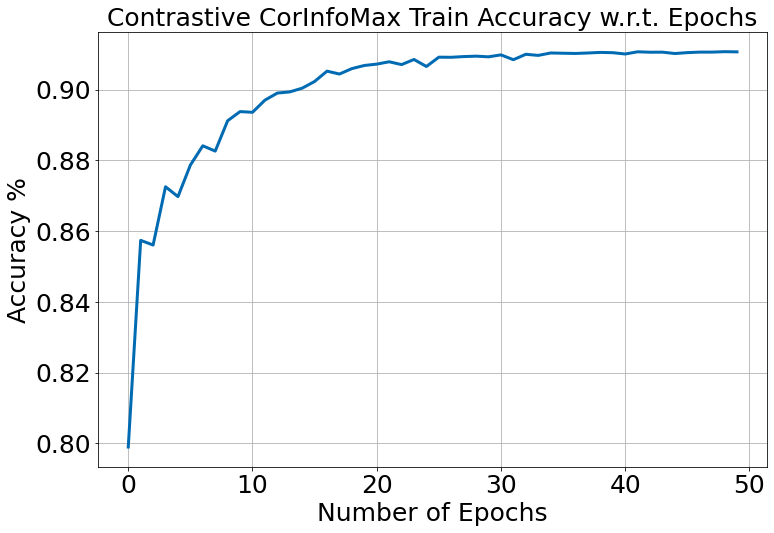

In [7]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

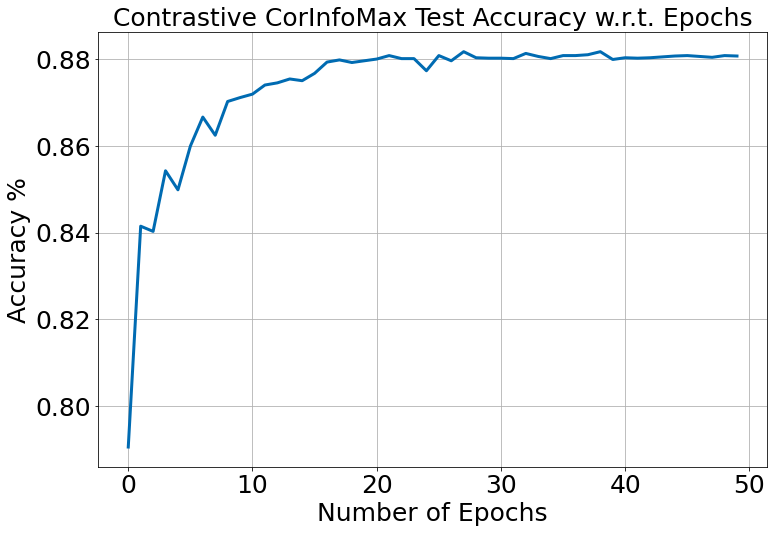

In [8]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [9]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [10]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [11]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [12]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [13]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])